In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.graph_objs as go
import plotly.express as px
import plotly.offline as pyo
from IPython.display import display, Markdown, HTML

In [2]:
# exclude the closing price of the previous day in the calculation of tha daily volatility?
intraday = True




# Read CSV into a DataFrame
dailyNdteOptionsVolume = pd.read_csv("dailyNdteOptionsVolume.csv", dayfirst=True)
# Set the 'date' column as the index
dailyNdteOptionsVolume.set_index('date', inplace=True)
dailyNdteOptionsVolume.index = pd.to_datetime(dailyNdteOptionsVolume.index)

# Calculate percentage columns
percentage_cols = [col.replace('cnt', 'pct') for col in dailyNdteOptionsVolume.columns]
dailyNdteOptionsVolume[percentage_cols] = dailyNdteOptionsVolume.div(dailyNdteOptionsVolume.sum(axis=1), axis=0)

# Create a new column 'total_cnt' that contains the sum of columns that ends with "_cnt"
dailyNdteOptionsVolume['total_cnt'] = dailyNdteOptionsVolume.filter(like='_cnt').sum(axis=1)

# Drop rows where there were 0 options trades
dailyNdteOptionsVolume = dailyNdteOptionsVolume[dailyNdteOptionsVolume['total_cnt'] != 0]

# For Instrumental Variable test. average of 0dte% between 5 days and 15 trading days ago is unlikely to affect volatility
dailyNdteOptionsVolume.sort_index(ascending=True, inplace=True)
dailyNdteOptionsVolume['lagged_0dte_avg_pct'] = dailyNdteOptionsVolume['0dte_pct'].shift(5).rolling(window=10, min_periods=1).apply(lambda x: x[x != 0].mean()) # (lambda x: x[x != 0].mean())




# read spx volatility 
spxIntradayVolatility  = pd.read_csv(f"spx{'Intraday' if intraday else ''}Volatility.csv", dayfirst=True)
spxIntradayVolatility.set_index('date', inplace=True)
spxIntradayVolatility.index = pd.to_datetime(spxIntradayVolatility.index)

# Add a 1M rolling volatility
spxIntradayVolatility.sort_index(ascending=True, inplace=True)
spxIntradayVolatility['lagged_avg_volatility'] = spxIntradayVolatility['volatility'].shift(1).rolling(window=1).mean()



# create one master dataframe
data = pd.merge(spxIntradayVolatility, dailyNdteOptionsVolume, left_index=True, right_index=True)

# filter out days without and 0dte trades
nonFiltereddata = data
data = data[data['0dte_cnt'] != 0]

In [3]:
nonFiltereddata

volatility    return  lagged_avg_volatility  0dte_cnt  1dte_cnt  \
date                                                                          
2013-04-10    0.030307  0.006823                    NaN         0         0   
2013-04-11    0.034845  0.002857               0.030307         0    176460   
2013-04-12    0.035595  0.001399               0.034845    110430         0   
2013-04-15    0.039357 -0.017612               0.035595         0         0   
2013-04-16    0.037886  0.006417               0.039357         0         0   
...                ...       ...                    ...       ...       ...   
2023-09-27    0.047356 -0.002355               0.035583   1765785    412795   
2023-09-28    0.045618  0.004030               0.047356   1537853    538969   
2023-09-29    0.044574 -0.009590               0.045618   1755373    398497   
2023-10-02    0.050888  0.001366               0.044574   1442112    361506   
2023-10-03    0.053308 -0.011277               0.050888   1644742    392443   

            2dte_cnt  3dte_cnt  4dte_cnt  5to21dte_cnt  22to43dte_cnt  ...  \
date                                                                   ...   
2013-04-10    271168         0         0        325713         225783  ...   
2013-04-11         0         0         0        371869         215422  ...   
2013-04-12         0         0         0        373228         144383  ...   
2013-04-15         0         0    395514         99675         266144  ...   
2013-04-16         0    252022         0         61227         141109  ...   
...              ...       ...       ...           ...            ...  ...   
2023-09-27    323868     70962     19480        453019         151147  ...   
2023-09-28     73397     28997     25561        322139         133063  ...   
2023-09-29     77243     47577     35107        582744         320850  ...   
2023-10-02    138138     46052    131799        394646         114960  ...   
2023-10-03    102477    138286     42071        486443         283437  ...   

            1dte_pct  2dte_pct  3dte_pct  4dte_pct  5to21dte_pct  \
date                                                               
2013-04-10  0.000000  0.223238  0.000000  0.000000      0.268143   
2013-04-11  0.148179  0.000000  0.000000  0.000000      0.312270   
2013-04-12  0.000000  0.000000  0.000000  0.000000      0.420941   
2013-04-15  0.000000  0.000000  0.000000  0.365818      0.092191   
2013-04-16  0.000000  0.000000  0.371701  0.000000      0.090302   
...              ...       ...       ...       ...           ...   
2023-09-27  0.113282  0.088878  0.019474  0.005346      0.124321   
2023-09-28  0.178408  0.024296  0.009599  0.008461      0.106634   
2023-09-29  0.099499  0.019286  0.011879  0.008766      0.145503   
2023-10-02  0.122346  0.046751  0.015586  0.044605      0.133562   
2023-10-03  0.105971  0.027672  0.037341  0.011360      0.131354   

            22to43dte_pct  44to64dte_pct  higher_dte_pct  total_cnt  \
date                                                                  
2013-04-10       0.185875       0.213154        0.109590    1214701   
2013-04-11       0.180897       0.228953        0.129702    1190857   
2013-04-12       0.162841       0.180179        0.111492     886652   
2013-04-15       0.246162       0.186658        0.109171    1081176   
2013-04-16       0.208118       0.183334        0.146544     678023   
...                   ...            ...             ...        ...   
2023-09-27       0.041479       0.060511        0.062129    3643947   
2023-09-28       0.044046       0.070194        0.049305    3020986   
2023-09-29       0.080112       0.147441        0.049222    4005033   
2023-10-02       0.038907       0.061342        0.048840    2954776   
2023-10-03       0.076536       0.090207        0.075430    3703302   

            lagged_0dte_avg_pct  
date                             
2013-04-10                  NaN  
2013-04-11                  NaN  
2013-04-12              

In [4]:
# split the dataset on the last day without 0dte trades
lastDayWithoutTrades = datetime(2022, 5, 12)

beforeDailiy0dteTrading = data[data.index <= lastDayWithoutTrades]
afterDailiy0dteTrading  = data[data.index >  lastDayWithoutTrades]

In [5]:
print(nonFiltereddata[nonFiltereddata.index <= lastDayWithoutTrades].shape)
print(nonFiltereddata[nonFiltereddata.index >  lastDayWithoutTrades].shape)
print(beforeDailiy0dteTrading.shape)
print(afterDailiy0dteTrading.shape)

(2288, 23)
(349, 23)
(1083, 23)
(349, 23)


# 0dte%

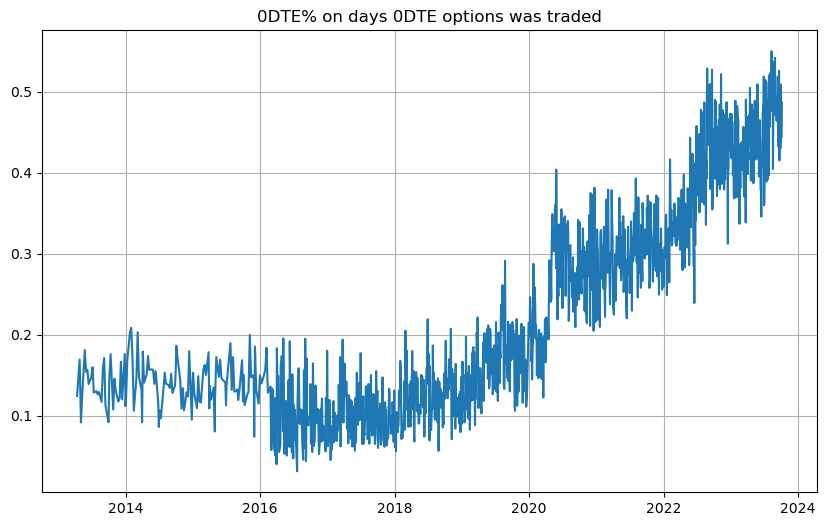

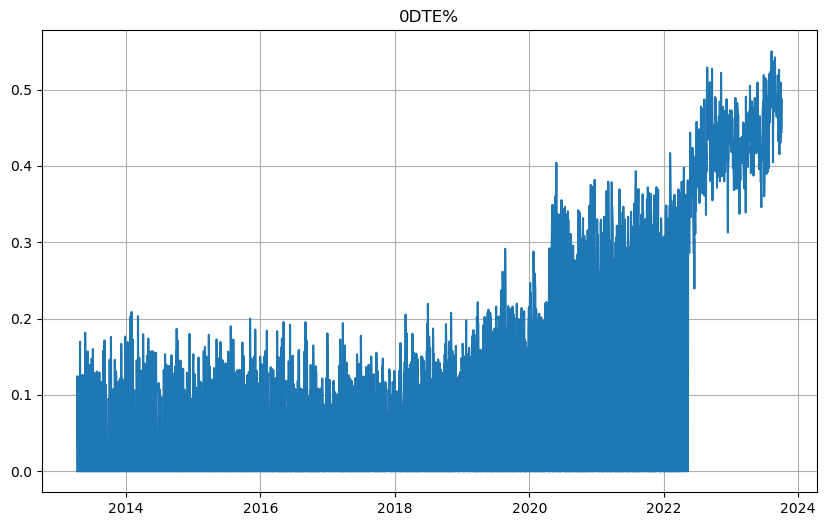

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["0dte_pct"])
plt.grid(True)
plt.title("0DTE% on days 0DTE options was traded")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(nonFiltereddata.index, nonFiltereddata["0dte_pct"])
plt.grid(True)
plt.title("0DTE%")
plt.show()

In [7]:
monthlyNdteOptionsVolume = nonFiltereddata.groupby([nonFiltereddata.index.year, nonFiltereddata.index.month]).agg({
    '0dte_cnt': 'sum',
    '1dte_cnt': 'sum',
    '2dte_cnt': 'sum',
    '3dte_cnt': 'sum',
    '4dte_cnt': 'sum',
    '5to21dte_cnt'  : 'sum', 
    '22to43dte_cnt' : 'sum', 
    '44to64dte_cnt' : 'sum',
    'higher_dte_cnt': 'sum'
}).rename_axis(['year', 'month'])

# Calculate percentage columns
percentage_cols = [col.replace('cnt', 'pct') for col in monthlyNdteOptionsVolume.columns]
monthlyNdteOptionsVolume[percentage_cols] = monthlyNdteOptionsVolume.div(monthlyNdteOptionsVolume.sum(axis=1), axis=0)

# Create a new column 'Date' with a datetime object
monthlyNdteOptionsVolume.reset_index(inplace=True)
monthlyNdteOptionsVolume['date'] = pd.to_datetime(monthlyNdteOptionsVolume[['year', 'month']].assign(DAY=1))


monthlyNdteOptionsVolume

year  month  0dte_cnt  1dte_cnt  2dte_cnt  3dte_cnt  4dte_cnt  \
0    2013      4    227176    797682    855077    531583    613123   
1    2013      5    531797   1007466   1129072    816307    561711   
2    2013      6    383797   1317091    705074    639887    886595   
3    2013      7    328453    779756    851825    617488    509732   
4    2013      8    374258    908194    551375    614003    667425   
..    ...    ...       ...       ...       ...       ...       ...   
122  2023      6  25809003   6976447   2668462   1559807   1786327   
123  2023      7  23392323   6050677   2400349   1410867   1046678   
124  2023      8  32911909   7761259   2810456   1581274   1308961   
125  2023      9  27716301   7036471   2455602   1479794   1253151   
126  2023     10   3086854    753949    240615    184338    173870   

     5to21dte_cnt  22to43dte_cnt  44to64dte_cnt  ...  0dte_pct  1dte_pct  \
0         4061840        2416081        2003145  ...  0.017680  0.062081   
1         6158331        5766417        1301472  ...  0.025890  0.049048   
2         7395883        3281043        1902118  ...  0.019671  0.067506   
3         5171740        3431075        2800220  ...  0.019848  0.047120   
4         6111220        4391116         936205  ...  0.022996  0.055804   
..            ...            ...            ...  ...       ...       ...   
122       9125761        3725898        3316407  ...  0.428324  0.115781   
123       6881539        4358998        1946707  ...  0.454178  0.117478   
124       9889864        3895382        1551083  ...  0.498513  0.117559   
125       8018705        3783205        3196238  ...  0.471184  0.119622   
126        881089         398397         515313  ...  0.463625  0.113238   

     2dte_pct  3dte_pct  4dte_pct  5to21dte_pct  22to43dte_pct  44to64dte_pct  \
0    0.066548  0.041372  0.047718      0.316122       0.188037       0.155899   
1    0.054969  0.039742  0.027347      0.299817       0.280737       0.063362   
2    0.036138  0.032797  0.045442      0.379069       0.168167       0.097491   
3    0.051475  0.037314  0.030803      0.312525       0.207338       0.169215   
4    0.033879  0.037727  0.041010      0.375502       0.269811       0.057525   
..        ...       ...       ...           ...            ...            ...   
122  0.044286  0.025886  0.029646      0.151451       0.061835       0.055039   
123  0.046604  0.027393  0.020322      0.133610       0.084633       0.037797   
124  0.042570  0.023951  0.019827      0.149801       0.059003       0.023494   
125  0.041746  0.025157  0.021304      0.136320       0.064315       0.054337   
126  0.036139  0.027686  0.026114      0.132334       0.059837       0.077397   

     higher_dte_pct       date  
0          0.104543 2013-04-01  
1          0.159088 2013-05-01  
2          0.153719 2013-06-01  
3          0.124361 2013-07-01  
4          0.105746 2013-08-01  
..              ...        ...  
122        0.087753 2023-06-01  
123        0.077985 2023-07-01  
124        0.065282 2023-08-01  
125        0.066016 2023-09-01  
126        0.063630 2023-10-01  

[127 rows x 21 columns]

In [8]:
yearlyNdteOptionsVolume = nonFiltereddata.groupby(nonFiltereddata.index.year).agg({
    '0dte_cnt': 'sum',
    '1dte_cnt': 'sum',
    '2dte_cnt': 'sum',
    '3dte_cnt': 'sum',
    '4dte_cnt': 'sum',
    '5to21dte_cnt'  : 'sum', 
    '22to43dte_cnt' : 'sum', 
    '44to64dte_cnt' : 'sum',
    'higher_dte_cnt': 'sum'
})

# Calculate percentage columns
percentage_cols = [col.replace('cnt', 'pct') for col in yearlyNdteOptionsVolume.columns]
yearlyNdteOptionsVolume[percentage_cols] = yearlyNdteOptionsVolume.div(yearlyNdteOptionsVolume.sum(axis=1), axis=0)

yearlyNdteOptionsVolume

0dte_cnt  1dte_cnt  2dte_cnt  3dte_cnt  4dte_cnt  5to21dte_cnt  \
date                                                                    
2013    3431659   8565471   7863643   6152353   6432043      54356478   
2014    6512551  11644776  10279397   9708168  11360816      87950539   
2015    7167756  11906315  11135258  10990481  12323371      96301034   
2016   11971110  16857513  12876828  10666925  10495567      88531780   
2017   18668390  21471937  14846079  11367159  11623287     105095787   
2018   28802685  28617445  18678319  13688742  13642386     123939109   
2019   34776258  28158127  17599665  11164332   9999907      97711626   
2020   53300805  32184779  18421640  11110677  10777240      82280879   
2021   71927709  44997540  25490484  15060074  14575312      85139797   
2022  200908938  67323742  27978352  17063288  16956931      95841170   
2023  231520865  63091454  22957316  13803387  12716676      74101248   

      22to43dte_cnt  44to64dte_cnt  higher_dte_cnt  0dte_pct  1dte_pct  \
date                                                                     
2013       32451020       16485171        19148851  0.022156  0.055302   
2014       46490106       19538236        21713488  0.028919  0.051709   
2015       48802497       20075998        19099302  0.030142  0.050068   
2016       58213877       23634502        25461375  0.046272  0.065160   
2017       60605384       20927503        25207757  0.064415  0.074089   
2018       81341965       29061800        32046783  0.077883  0.077382   
2019       59479770       24413732        36455967  0.108758  0.088060   
2020       41203940       22964956        39587491  0.170928  0.103212   
2021       35532134       21050960        31921966  0.208066  0.130165   
2022       47657801       29227397        46792628  0.365455  0.122462   
2023       35138762       21526479        42813315  0.447237  0.121876   

      2dte_pct  3dte_pct  4dte_pct  5to21dte_pct  22to43dte_pct  \
date                                                              
2013  0.050770  0.039722  0.041527      0.350944       0.209515   
2014  0.045646  0.043109  0.050448      0.390547       0.206441   
2015  0.046826  0.046217  0.051822      0.404963       0.205223   
2016  0.049773  0.041231  0.040569      0.342205       0.225016   
2017  0.051226  0.039222  0.040106      0.362633       0.209119   
2018  0.050507  0.037015  0.036889      0.335134       0.219951   
2019  0.055040  0.034915  0.031273      0.305579       0.186014   
2020  0.059075  0.035630  0.034561      0.263863       0.132135   
2021  0.073737  0.043565  0.042162      0.246285       0.102784   
2022  0.050893  0.031038  0.030845      0.174336       0.086690   
2023  0.044347  0.026664  0.024565      0.143144       0.067879   

      44to64dte_pct  higher_dte_pct  
date                                 
2013       0.106434        0.123631  
2014       0.086760        0.096420  
2015       0.084423        0.080316  
2016       0.091355        0.098417  
2017       0.072210        0.086979  
2018       0.078584        0.086655  
2019       0.076350        0.114011  
2020       0.073645        0.126951  
2021       0.060894        0.092341  
2022       0.053165        0.085116  
2023       0.041583        0.082704

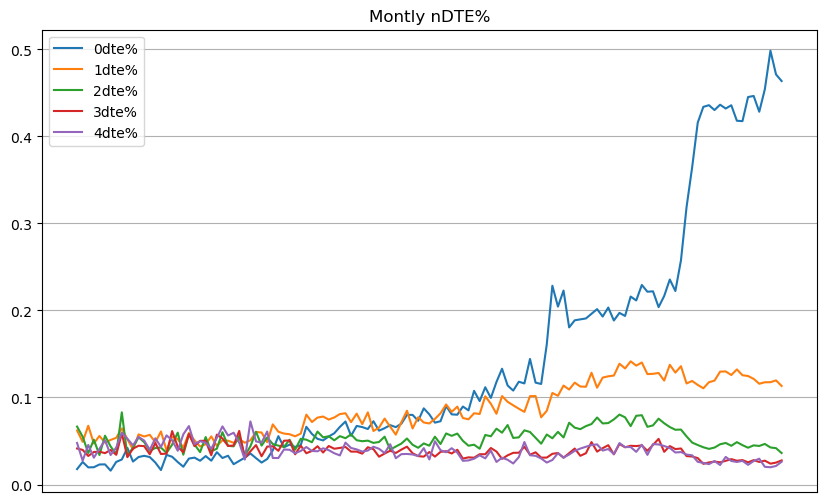

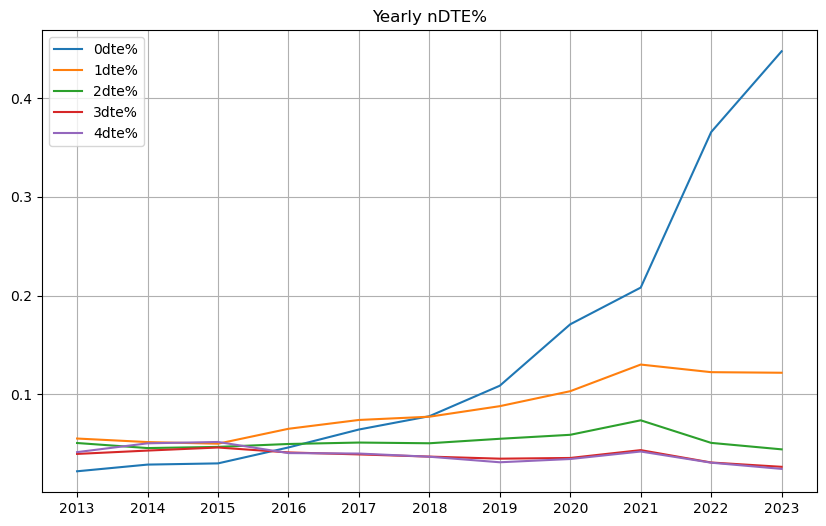

In [9]:

plt.figure(figsize=(10, 6))
plt.plot(monthlyNdteOptionsVolume.index, monthlyNdteOptionsVolume["0dte_pct"], label="0dte%")
plt.plot(monthlyNdteOptionsVolume.index, monthlyNdteOptionsVolume["1dte_pct"], label="1dte%")
plt.plot(monthlyNdteOptionsVolume.index, monthlyNdteOptionsVolume["2dte_pct"], label="2dte%")
plt.plot(monthlyNdteOptionsVolume.index, monthlyNdteOptionsVolume["3dte_pct"], label="3dte%")
plt.plot(monthlyNdteOptionsVolume.index, monthlyNdteOptionsVolume["4dte_pct"], label="4dte%")
plt.xticks(monthlyNdteOptionsVolume.index)
plt.gca().axes.get_xaxis().set_visible(False)
plt.grid(True)
plt.legend()
plt.title("Montly nDTE%")
plt.show()




#plot
plt.figure(figsize=(10, 6))
plt.plot(yearlyNdteOptionsVolume.index, yearlyNdteOptionsVolume["0dte_pct"], label="0dte%")
plt.plot(yearlyNdteOptionsVolume.index, yearlyNdteOptionsVolume["1dte_pct"], label="1dte%")
plt.plot(yearlyNdteOptionsVolume.index, yearlyNdteOptionsVolume["2dte_pct"], label="2dte%")
plt.plot(yearlyNdteOptionsVolume.index, yearlyNdteOptionsVolume["3dte_pct"], label="3dte%")
plt.plot(yearlyNdteOptionsVolume.index, yearlyNdteOptionsVolume["4dte_pct"], label="4dte%")
plt.grid(True)
plt.xticks(yearlyNdteOptionsVolume.index)
plt.legend()
plt.title("Yearly nDTE%")
plt.show()

In [10]:
monthlyNdteOptionsVolume["3to21dte_pct"] = monthlyNdteOptionsVolume["3dte_pct"] + monthlyNdteOptionsVolume["4dte_pct"] + monthlyNdteOptionsVolume["5to21dte_pct"]
monthlyNdteOptionsVolume["higher_than_21dte_pct"] = monthlyNdteOptionsVolume["22to43dte_pct"] + monthlyNdteOptionsVolume["44to64dte_pct"] + monthlyNdteOptionsVolume["higher_dte_pct"]

# Create traces for each line
trace0 = go.Scatter(x=monthlyNdteOptionsVolume["date"], y=monthlyNdteOptionsVolume["0dte_pct"],
                    mode='lines', showlegend=False,
                    line=dict(color='red', width=5),
                    )

trace0star = go.Scatter(x=[monthlyNdteOptionsVolume.iloc[-1].date],
                        y=[monthlyNdteOptionsVolume.iloc[-1]["0dte_pct"]],
                        mode='markers', showlegend=False,
                        marker=dict(size=15, color='red', symbol='star', line=dict(color='black', width=2)))

trace0label = go.Scatter(x=[datetime(2015,1,1)],y=[-1],
                    mode='lines', name='0', 
                    line=dict(color='red', width=4),
                    marker=dict(size=10, color='red', symbol='star', line=dict(color='black', width=2)),
                    )

trace1 = go.Scatter(x=monthlyNdteOptionsVolume["date"], y=monthlyNdteOptionsVolume["1dte_pct"],
                    mode='lines', name='1', opacity=0.5)

trace2 = go.Scatter(x=monthlyNdteOptionsVolume["date"], y=monthlyNdteOptionsVolume["2dte_pct"],
                    mode='lines', name='2', opacity=0.5)

trace3 = go.Scatter(x=monthlyNdteOptionsVolume["date"], y=monthlyNdteOptionsVolume["3to21dte_pct"],
                    mode='lines', name='3 to 21', opacity=0.5)

trace4 = go.Scatter(x=monthlyNdteOptionsVolume["date"], y=monthlyNdteOptionsVolume["higher_than_21dte_pct"],
                    mode='lines', name='higher', opacity=0.5)

# Create figure and add traces
fig = go.Figure(data=[trace0label, trace1, trace2, trace3, trace4, trace0])


fig.update_layout(
    xaxis=dict(range=[monthlyNdteOptionsVolume.iloc[0].date, datetime(2023, 12, 1)]),
    yaxis=dict(range=[0, 0.6]),
)

# Create ticks for years only from 2013 to 2019
year_ticks = [datetime(year, 1, 1) for year in range(2013, 2020)]

# Create ticks for years and quarters from 2020 onward
quarter_ticks = [
    datetime(year, month * 3 - 2, 1) for year in range(2020, 2024) for month in range(1, 5)
]





# Combine the two sets of ticks
all_ticks = year_ticks + quarter_ticks

# Update x-axis ticks
fig.update_xaxes(
    tickmode='array',
    tickvals=[tick.timestamp() * 1000 for tick in all_ticks],
    ticktext=[
        ("Q"+str((tick.month-1)//3+1)+" "+str(tick.strftime('%Y') if (tick.month-1)//3+1==1 else "")) if tick.year >= 2020 else tick.strftime('%Y')
        for tick in all_ticks
    ],
)

# Update y-axis ticks
fig.update_yaxes(
    tickformat='0%',
)

fig.update_layout(
    title='S&P 500 0DTE options have surged in popularity',
    yaxis=dict(title='Percentage of total options volume'),
    legend=dict(x=0.69, y=1, traceorder='normal', orientation='h'),
    xaxis_showgrid=False,
    #yaxis_showgrid=False,
)

# Show the plot
fig.show()
pyo.plot(fig, filename='overview.html')

C:\Users\bendi\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



'overview.html'

In [11]:
yearlyNdteOptionsVolume["3to21dte_pct"] = yearlyNdteOptionsVolume["3dte_pct"] + yearlyNdteOptionsVolume["4dte_pct"] + yearlyNdteOptionsVolume["5to21dte_pct"]
yearlyNdteOptionsVolume["higher_than_21dte_pct"] = yearlyNdteOptionsVolume["22to43dte_pct"] + yearlyNdteOptionsVolume["44to64dte_pct"] + yearlyNdteOptionsVolume["higher_dte_pct"]

# Create traces for each line
trace0 = go.Scatter(x=yearlyNdteOptionsVolume.index, y=yearlyNdteOptionsVolume["0dte_pct"],
                    mode='lines', showlegend=False,
                    line=dict(color='red', width=5),
                    )


trace0label = go.Scatter(x=[datetime(2015,1,1)],y=[-1],
                    mode='lines', name='0dte', 
                    line=dict(color='red', width=4),
                    marker=dict(size=10, color='red', symbol='star', line=dict(color='black', width=2)),
                    )

trace1 = go.Scatter(x=yearlyNdteOptionsVolume.index, y=yearlyNdteOptionsVolume["1dte_pct"],
                    mode='lines', name='1dte', opacity=0.5)

trace2 = go.Scatter(x=yearlyNdteOptionsVolume.index, y=yearlyNdteOptionsVolume["2dte_pct"],
                    mode='lines', name='2dte', opacity=0.5)

trace3 = go.Scatter(x=yearlyNdteOptionsVolume.index, y=yearlyNdteOptionsVolume["3to21dte_pct"],
                    mode='lines', name='3to21dte', opacity=0.5)

trace4 = go.Scatter(x=yearlyNdteOptionsVolume.index, y=yearlyNdteOptionsVolume["higher_than_21dte_pct"],
                    mode='lines', name='higher dte', opacity=0.5)

# Create figure and add traces
fig = go.Figure(data=[trace0label, trace1, trace2, trace3, trace4, trace0])


fig.update_layout(
    xaxis=dict(range=[yearlyNdteOptionsVolume.iloc[0].index, datetime(2023, 12, 1)]),
    yaxis=dict(range=[0, 0.55]),
)


ticks = [datetime(year,1,1) for year in range(2013,2024)]
# Update x-axis ticks
fig.update_xaxes(
    tickmode='array',
    tickvals=ticks,
    ticktext=["Since Apr 12, 2013" if tick.year == 2013 else 
              ("To Oct 3rd, 2023" if tick.year == 2023 else tick.year)
              for tick in ticks],
)

# Update y-axis ticks
fig.update_yaxes(
    tickformat='0%',
)

fig.update_layout(
    title='S&P 500 0DTE volume as a percentage of total options volume',
    yaxis=dict(title='Percentage of total volume'),
    legend=dict(x=0.69, y=1, traceorder='normal', orientation='h'),
)

# Show the plot
fig.show()
pyo.plot(fig, filename='overviewYear.html')

'overviewYear.html'

# 0DTE has clearly the biggest impact and explanatory power

And 0dte_pct explains volatility better than what lagged_0dte_avg_pct does (lagged_0dte_avg_pct is significant with a higher r^2 and a lower coefficient). Conclusion is that while is the best predictor of volatility, volatility itself causes 0dte% too. Based on data before dailiy trading.

In [12]:
print("=============================================================================")
print("OLS Regression Results: Volatility and nDTE% from 2013/04/12 to 2022/05/11")
print("=============================================================================")

results = {"Variable": [], "Coefficient": [], "R-squared": [], "P-value": []}

for n, var in enumerate(beforeDailiy0dteTrading.filter(like='_pct').columns):
    # Prepare the data for regression
    d = beforeDailiy0dteTrading[[var, 'volatility']].replace(0, np.nan).dropna() # because 5d_lagged_0dte_pct  countains nan
    
    X = sm.add_constant(d[var]) # independent variables
    y = d['volatility']  # dependent variable

    # Fit the regression model
    model = sm.OLS(y, X).fit()

    #print results
    b = model.params[1]
    r = model.rsquared
    p = model.pvalues[1]

    results["Variable"]   .append(var)
    results["Coefficient"].append(b)
    results["R-squared"]  .append(r)
    results["P-value"]    .append(p)
    
    print(var, f"{' ' * (19 - len(var)) }| coefficient:{'' if b<0 else ' '}", "%.3f" % b, "| r-squared:", "%.3f" % r, "| p value:", "%.3f" % p)

OLS Regression Results: Volatility and nDTE% from 2013/04/12 to 2022/05/11
0dte_pct            | coefficient:  0.052 | r-squared: 0.119 | p value: 0.000
1dte_pct            | coefficient:  0.035 | r-squared: 0.005 | p value: 0.148
2dte_pct            | coefficient:  0.015 | r-squared: 0.003 | p value: 0.143
3dte_pct            | coefficient: -0.035 | r-squared: 0.007 | p value: 0.035
4dte_pct            | coefficient: -0.020 | r-squared: 0.008 | p value: 0.048
5to21dte_pct        | coefficient: -0.020 | r-squared: 0.029 | p value: 0.000
22to43dte_pct       | coefficient: -0.031 | r-squared: 0.040 | p value: 0.000
44to64dte_pct       | coefficient:  0.005 | r-squared: 0.000 | p value: 0.557
higher_dte_pct      | coefficient:  0.053 | r-squared: 0.019 | p value: 0.000
lagged_0dte_avg_pct | coefficient:  0.045 | r-squared: 0.079 | p value: 0.000


C:\Users\bendi\AppData\Local\Temp\ipykernel_16636\1133174269.py:18: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\bendi\AppData\Local\Temp\ipykernel_16636\1133174269.py:20: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\bendi\AppData\Local\Temp\ipykernel_16636\1133174269.py:18: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\bendi\AppData\Local\Temp\ipykernel_16636\1133174269.py:20: FutureWarning:

Series.__g

In [13]:
df = pd.DataFrame(results)
df['P-value'] = df['P-value'].round(3)
df['Coefficient'] = df['Coefficient'].round(3)
df['R-squared'] = df['R-squared'].round(3)

display(Markdown("**OLS Regressions Results**"))
display(Markdown("Volatility and 0DTE% in each year from 2013"))
display(HTML(df.to_html(index=False)))

**OLS Regressions Results**

Volatility and 0DTE% in each year from 2013

# Negative 0dte impact on volatility in 2023, 2022, 2020

From, the 13th of may 2022, 0dte options was traded every day.

2015 is not significant. 2022 is not significant (because daily trading started lanuched mid year)

In [14]:
print("====================================================================")
print("OLS Regressions Results: Volatility and 0DTE% in each year from 2013")
print("====================================================================")

results = {"Year": [], "Coefficient": [], "R-squared": [], "P-value": []}

for year in sorted(set(data.index.year)):
    yearData = data.loc[data.index.year == year]
    
    # Prepare the data for regression
    X = sm.add_constant(yearData[["0dte_pct"]]) # independent variables
    y = yearData['volatility']  # dependent variable

    # Fit the regression model
    model = sm.OLS(y, X).fit()
    
    b = model.params[1]
    
    results["Year"]       .append(year)
    results["Coefficient"].append(b)
    results["R-squared"]  .append(model.rsquared)
    results["P-value"]    .append(model.pvalues["0dte_pct"])
    
    
    print(year, f"| coefficient:{'' if b<0 else ' '}", "%.3f" % b, "| R-squared:", "%.3f" % model.rsquared, "| 0dte% p value:", "%.3f" % model.pvalues["0dte_pct"])

OLS Regressions Results: Volatility and 0DTE% in each year from 2013
2013 | coefficient:  0.096 | R-squared: 0.143 | 0dte% p value: 0.036
2014 | coefficient:  0.146 | R-squared: 0.255 | 0dte% p value: 0.000
2015 | coefficient: -0.003 | R-squared: 0.000 | 0dte% p value: 0.953
2016 | coefficient:  0.060 | R-squared: 0.089 | 0dte% p value: 0.002
2017 | coefficient:  0.093 | R-squared: 0.162 | 0dte% p value: 0.000
2018 | coefficient:  0.104 | R-squared: 0.066 | 0dte% p value: 0.001
2019 | coefficient:  0.093 | R-squared: 0.131 | 0dte% p value: 0.000
2020 | coefficient: -0.072 | R-squared: 0.047 | 0dte% p value: 0.006
2021 | coefficient:  0.088 | R-squared: 0.103 | 0dte% p value: 0.000
2022 | coefficient: -0.019 | R-squared: 0.011 | 0dte% p value: 0.121
2023 | coefficient: -0.032 | R-squared: 0.026 | 0dte% p value: 0.027


C:\Users\bendi\AppData\Local\Temp\ipykernel_16636\842918451.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\bendi\AppData\Local\Temp\ipykernel_16636\842918451.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\bendi\AppData\Local\Temp\ipykernel_16636\842918451.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\bendi\AppData\Local\Temp\ipykernel_16636\842918451.py:17: FutureWarning:

Series.__getit

In [15]:
df = pd.DataFrame(results)
df['P-value'] = df['P-value'].round(3)
df['Coefficient'] = df['Coefficient'].round(3)
df['R-squared'] = df['R-squared'].round(3)

display(Markdown("**OLS Regressions Results**"))
display(Markdown("Volatility and 0DTE% in each year from 2013"))
display(HTML(df.to_html(index=False)))

**OLS Regressions Results**

Volatility and 0DTE% in each year from 2013

# OLS Regression across the entire dataset

                            OLS Regression Results                            
Dep. Variable:             volatility   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     192.4
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           3.87e-41
Time:                        09:06:34   Log-Likelihood:                 4239.5
No. Observations:                1432   AIC:                            -8475.
Df Residuals:                    1430   BIC:                            -8464.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0308      0.001     44.997      0.0

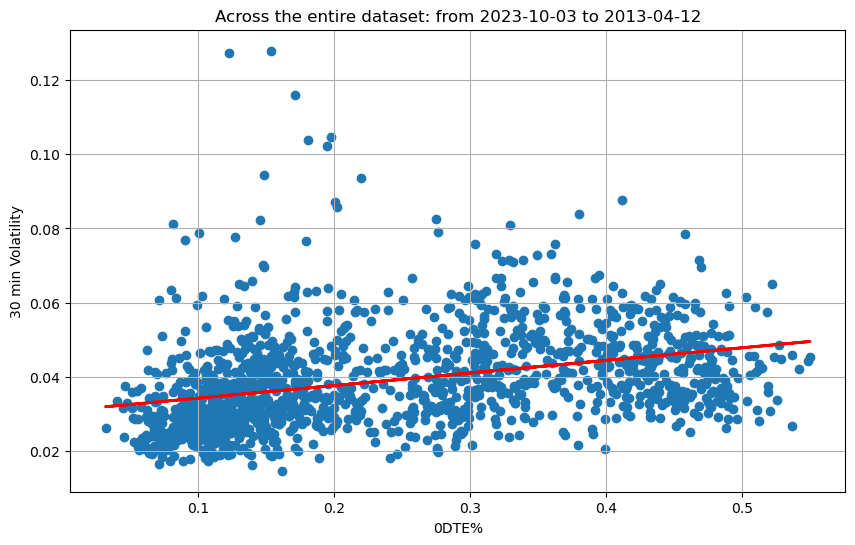

R-squared:  0.119
p value:  0.000
coefficient:  0.034


In [16]:
# Prepare the data for regression
X = sm.add_constant(data[["0dte_pct"]]) # independent variables
y = data['volatility']  # dependent variable

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(data["0dte_pct"], data["volatility"])
plt.grid(True)
# Add the regression line
plt.plot(data["0dte_pct"], model.predict(sm.add_constant(data[["0dte_pct"]])), color='red', linewidth=2)
plt.xlabel("0DTE%")
plt.ylabel("30 min Volatility")
plt.title(f"Across the entire dataset: from " + data.index.max().strftime("%Y-%m-%d") + " to " + data.index.min().strftime("%Y-%m-%d"))
plt.show()

print("R-squared: ",     "%.3f" % model.rsquared)
print("p value: ",       "%.3f" % model.pvalues["0dte_pct"])
print("coefficient: ",   "%.3f" % model.params["0dte_pct"])

# OLS Regression before Dailiy 0dte Trading

In [17]:
# Prepare the data for regression
X = sm.add_constant(beforeDailiy0dteTrading[["0dte_pct"]]) # independent variables
y = beforeDailiy0dteTrading['volatility']  # dependent variable

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             volatility   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     146.3
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           1.11e-31
Time:                        09:06:35   Log-Likelihood:                 3189.7
No. Observations:                1083   AIC:                            -6375.
Df Residuals:                    1081   BIC:                            -6365.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0277      0.001     31.449      0.0

In [18]:
#One standard deviation
data["0dte_pct"].std()

0.13526153322480672

In [19]:
#One standard deviation, January to October 2023.
data[data.index>datetime(2023,1,1)]["0dte_pct"].std()

0.043134768566128315

In [20]:
# # Plotting
# plt.figure(figsize=(10, 6))
# plt.scatter(beforeDailiy0dteTrading["0dte_pct"], beforeDailiy0dteTrading["volatility"])
# plt.grid(True)
# # Add the regression line
# plt.plot(beforeDailiy0dteTrading["0dte_pct"], model.predict(sm.add_constant(beforeDailiy0dteTrading[["0dte_pct"]])), color='red', linewidth=2)
# plt.xlabel("0DTE%")
# plt.ylabel("30 min Volatility")
# plt.title(f"Before Dailiy 0dte Trading: from " + beforeDailiy0dteTrading.index.min().strftime("%Y-%m-%d") + " to " + beforeDailiy0dteTrading.index.max().strftime("%Y-%m-%d"))
# # Add text
# info_text = (
#     f"R-squared: {model.rsquared:.3f}\n"
#     f"P value:      {model.pvalues['0dte_pct']:.3f}\n"
#     f"Coefficient: {model.params['0dte_pct']:.3f}"
# )
# 
# plt.text(0.72, 0.8, info_text, transform=plt.gca().transAxes, fontsize=15,
#          bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
# 
# plt.show()

In [21]:
# Scatter plot
scatter_trace = go.Scatter(x=beforeDailiy0dteTrading["0dte_pct"],
                          y=beforeDailiy0dteTrading["volatility"],
                          mode='markers',
                          marker=dict(size=8),
                          name='Data')

# Regression line
regression_trace = go.Scatter(x=beforeDailiy0dteTrading["0dte_pct"],
                             y=model.predict(sm.add_constant(beforeDailiy0dteTrading[["0dte_pct"]])),
                             mode='lines',
                             line=dict(color='red', width=2),
                             name='Regression Line')

# Add text annotation
info_text = (
    f"R-squared: {model.rsquared:.3f}<br>"
    f"P value:      {model.pvalues['0dte_pct']:.3f}<br>"
    f"Coefficient: {model.params['0dte_pct']:.3f}"
)

annotation = dict(x=0.878,
                  y=0.877,
                  xref="paper",
                  yref="paper",
                  text=info_text,
                  showarrow=False,
                  font=dict(size=15),
                  bgcolor='lightgray',
                  bordercolor='black',
                  borderwidth=1,
                  borderpad=5,
                  xanchor='left',
                  yanchor='bottom')

# Create the figure
fig = go.Figure(data=[scatter_trace, regression_trace])

# Add annotation
fig.add_annotation(annotation)

# Set layout properties
fig.update_layout(title=f"Before Daily 0dte Trading: from " + beforeDailiy0dteTrading.index.min().strftime("%Y-%m-%d") + " to " + beforeDailiy0dteTrading.index.max().strftime("%Y-%m-%d"),
                  xaxis_title="0DTE%",
                  yaxis_title="30 min Volatility",
                  xaxis=dict(range=[beforeDailiy0dteTrading["0dte_pct"].min()  *0.9, beforeDailiy0dteTrading["0dte_pct"].max()  *1.01]),
                  yaxis=dict(range=[beforeDailiy0dteTrading["volatility"].min()*0.87, beforeDailiy0dteTrading["volatility"].max()*1.02]))

# Show the plot
fig.show()
pyo.plot(fig, filename='regression1.html')

'regression1.html'

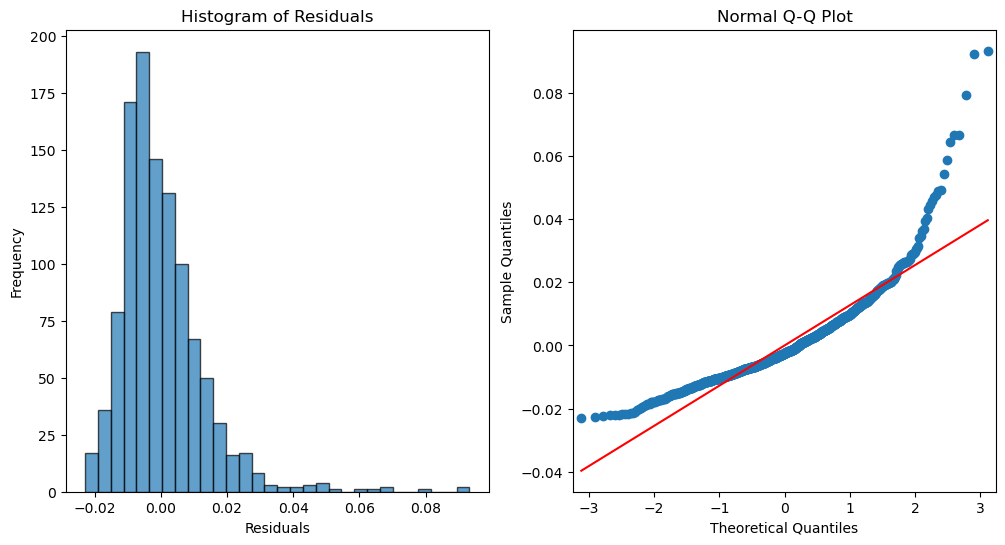

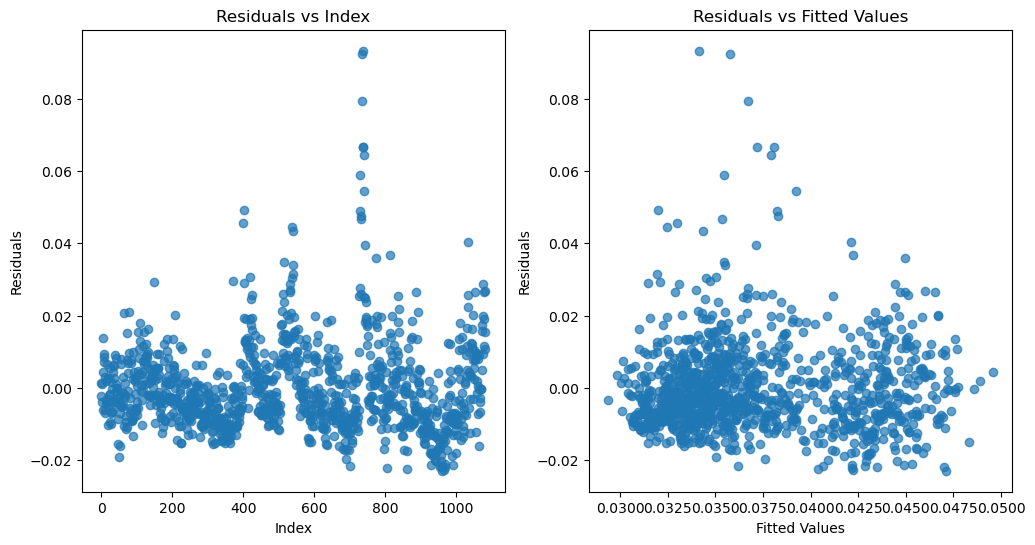

In [22]:
def diagnosis_plot(model):
    # Residuals
    residuals = model.resid

    # Index values
    index_values = np.arange(len(residuals))

    # Histogram of residuals
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')

    # Normal Q-Q plot
    plt.subplot(1, 2, 2)
    sm.qqplot(residuals, line='s', ax=plt.gca())
    plt.title('Normal Q-Q Plot')
    plt.show()

    # Residuals vs Index
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(index_values, residuals, alpha=0.7)
    plt.title('Residuals vs Index')
    plt.xlabel('Index')
    plt.ylabel('Residuals')

    # Residuals vs Fitted values
    plt.subplot(1, 2, 2)
    plt.scatter(model.fittedvalues, residuals, alpha=0.7)
    plt.title('Residuals vs Fitted Values')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.show()
    
diagnosis_plot(model)

# OLS Regression after Daily 0dte Trading

In [23]:
# Prepare the data for regression
X = sm.add_constant(afterDailiy0dteTrading[["0dte_pct"]]) # independent variables
y = afterDailiy0dteTrading['volatility']  # dependent variable

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             volatility   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     23.24
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           2.14e-06
Time:                        09:06:36   Log-Likelihood:                 1090.8
No. Observations:                 349   AIC:                            -2178.
Df Residuals:                     347   BIC:                            -2170.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0691      0.005     13.491      0.0

In [24]:
# Scatter plot
scatter_trace = go.Scatter(x=afterDailiy0dteTrading["0dte_pct"],
                          y=afterDailiy0dteTrading["volatility"],
                          mode='markers',
                          marker=dict(size=8),
                          name='Data')

# Regression line
regression_trace = go.Scatter(x=afterDailiy0dteTrading["0dte_pct"],
                             y=model.predict(sm.add_constant(afterDailiy0dteTrading[["0dte_pct"]])),
                             mode='lines',
                             line=dict(color='red', width=2),
                             name='Regression Line')

# Add text annotation
info_text = (
    f"R-squared: {model.rsquared:.3f}<br>"
    f"P value:      {model.pvalues['0dte_pct']:.3f}<br>"
    f"Coefficient: {model.params['0dte_pct']:.3f}"
)

annotation = dict(x=0.875,
                  y=0.877,
                  xref="paper",
                  yref="paper",
                  text=info_text,
                  showarrow=False,
                  font=dict(size=15),
                  bgcolor='lightgray',
                  bordercolor='black',
                  borderwidth=1,
                  borderpad=5,
                  xanchor='left',
                  yanchor='bottom')

# Create the figure
fig = go.Figure(data=[scatter_trace, regression_trace])

# Add annotation
fig.add_annotation(annotation)

# Set layout properties
fig.update_layout(title=f"After Daily 0dte Trading: from " + afterDailiy0dteTrading.index.min().strftime("%Y-%m-%d") + " to " + afterDailiy0dteTrading.index.max().strftime("%Y-%m-%d"),
                  xaxis_title="0DTE%",
                  yaxis_title="30 min Volatility",
                  xaxis=dict(range=[afterDailiy0dteTrading["0dte_pct"].min()  *0.98, afterDailiy0dteTrading["0dte_pct"].max()  *1.01]),
                  yaxis=dict(range=[afterDailiy0dteTrading["volatility"].min()*0.87, afterDailiy0dteTrading["volatility"].max()*1.02]))

# Show the plot
fig.show()
pyo.plot(fig, filename='regression2.html')

'regression2.html'

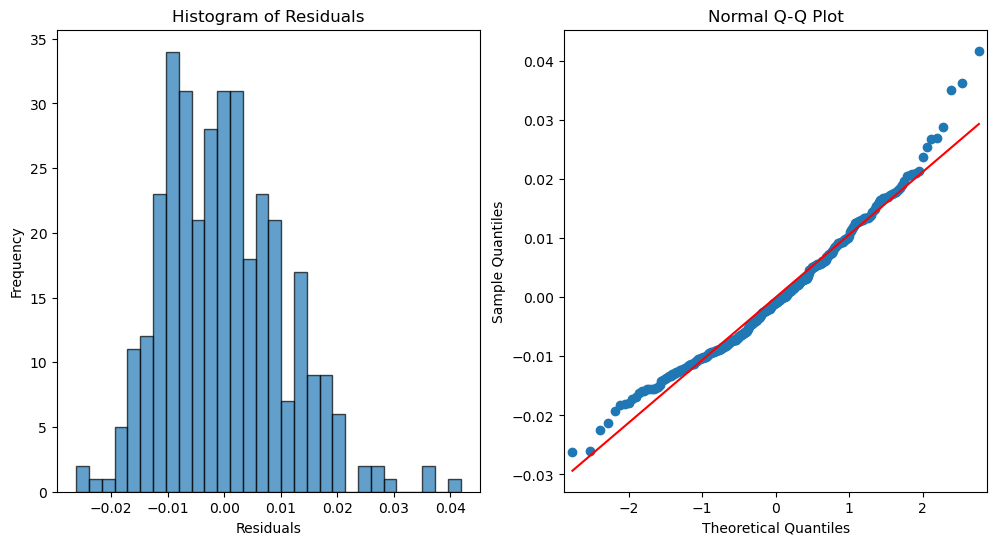

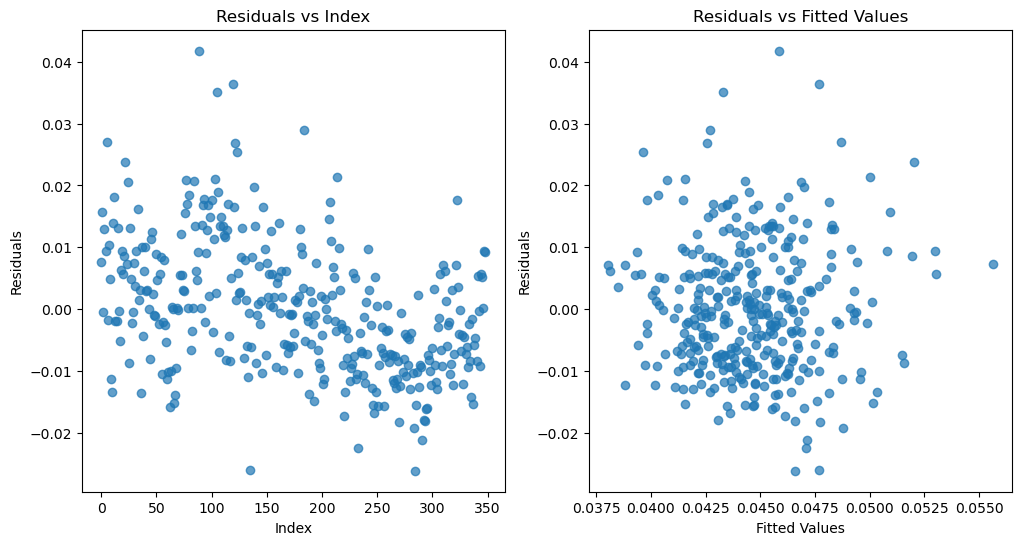

In [25]:
diagnosis_plot(model)

In [26]:
# # Plotting
# plt.figure(figsize=(10, 6))
# plt.scatter(afterDailiy0dteTrading["0dte_pct"], afterDailiy0dteTrading["volatility"])
# plt.grid(True)
# # Add the regression line
# plt.plot(afterDailiy0dteTrading["0dte_pct"], model.predict(sm.add_constant(afterDailiy0dteTrading[["0dte_pct"]])), color='red', linewidth=2)
# plt.xlabel("0DTE%")
# plt.ylabel("30 min Volatility")
# plt.title(f"After Dailiy 0dte Trading: from " + afterDailiy0dteTrading.index.max().strftime("%Y-%m-%d") + " to " + afterDailiy0dteTrading.index.min().strftime("%Y-%m-%d"))
# plt.show()
# 
# print("R-squared: ",     "%.3f" % model.rsquared)
# print("P value: ",       "%.3f" % model.pvalues["0dte_pct"])
# print("coefficient: ",   "%.3f" % model.params["0dte_pct"])

# With control variables

# OLS Regression before Dailiy 0dte Trading
nb: multicollinearity if total_cnt is included

In [27]:
beforeDailiy0dteTrading.columns

Index(['volatility', 'return', 'lagged_avg_volatility', '0dte_cnt', '1dte_cnt',
       '2dte_cnt', '3dte_cnt', '4dte_cnt', '5to21dte_cnt', '22to43dte_cnt',
       '44to64dte_cnt', 'higher_dte_cnt', '0dte_pct', '1dte_pct', '2dte_pct',
       '3dte_pct', '4dte_pct', '5to21dte_pct', '22to43dte_pct',
       '44to64dte_pct', 'higher_dte_pct', 'total_cnt', 'lagged_0dte_avg_pct'],
      dtype='object')

In [79]:
# past_average_volatility might be nan the first days. filter them out
cleaned = beforeDailiy0dteTrading[["volatility", "0dte_pct", "return", "lagged_avg_volatility"]].dropna()

# Prepare the data for regression
X = sm.add_constant(cleaned[["0dte_pct", "return", "lagged_avg_volatility"]]) # independent variables
y = cleaned['volatility']  # dependent variable

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

print("======================")
print("OLS Regression Results")
print("======================")

print("Data: Aggregate data per day from 2013 to May 2022")
print("Dep. Variable: volatility")
print("R-squared:",           "%.2f"  % model.rsquared)

print("p value 0DTE%:                  ",                  "%.2f" % model.pvalues["0dte_pct"])
print("p value same-day return:        ",        "%.2f" % model.pvalues["return"])
print("p value past average volatility:", "%.2f" % model.pvalues["lagged_avg_volatility"])

print("coefficient 0DTE%:                  ",                  "%.2f" % model.params["0dte_pct"])
print("coefficient same-day return:       ",        "%.2f" % model.params["return"])
print("coefficient past average volatility:", "%.2f" % model.params["lagged_avg_volatility"])

                            OLS Regression Results                            
Dep. Variable:             volatility   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     530.1
Date:                Tue, 07 Nov 2023   Prob (F-statistic):          1.62e-211
Time:                        09:11:42   Log-Likelihood:                 3605.1
No. Observations:                1081   AIC:                            -7202.
Df Residuals:                    1077   BIC:                            -7182.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

# Put call impact over time

In [29]:
# exclude the closing price of the previous day in the calculation of tha daily volatility?
intraday = True

# Read CSV into a DataFrame
dailyNdtePutCallVolume = pd.read_csv("dailyNdtePuttCallVolume.csv", dayfirst=True)
# Set the 'date' column as the index
dailyNdtePutCallVolume.set_index('date', inplace=True)
dailyNdtePutCallVolume.index = pd.to_datetime(dailyNdtePutCallVolume.index)

# Calculate percentage columns
percentage_cols = [col.replace('cnt', 'pct') for col in dailyNdtePutCallVolume.columns]
dailyNdtePutCallVolume[percentage_cols] = dailyNdtePutCallVolume.div(dailyNdtePutCallVolume.sum(axis=1), axis=0)

# Create a new column 'total_cnt' that contains the sum of columns that ends with "_cnt"
dailyNdtePutCallVolume['total_cnt'] = dailyNdtePutCallVolume.filter(like='_cnt').sum(axis=1)

# Drop rows where there were 0 options trades
dailyNdtePutCallVolume = dailyNdtePutCallVolume[dailyNdtePutCallVolume['total_cnt'] != 0]




# read spx volatility 
spxIntradayVolatility  = pd.read_csv(f"spx{'Intraday' if intraday else ''}Volatility.csv", dayfirst=True)
spxIntradayVolatility.set_index('date', inplace=True)
spxIntradayVolatility.index = pd.to_datetime(spxIntradayVolatility.index)

# Add a 1M rolling volatility
spxIntradayVolatility.sort_index(ascending=True, inplace=True)
spxIntradayVolatility['lagged_avg_volatility'] = spxIntradayVolatility['volatility'].shift(1).rolling(window=5).mean()



# create one master dataframe
dataPutCall = pd.merge(spxIntradayVolatility, dailyNdtePutCallVolume, left_index=True, right_index=True)

# filter out days without and 0dte trades
dataPutCall = dataPutCall[(dataPutCall['0dte_put_cnt'] != 0) | (dataPutCall['0dte_call_cnt'] != 0)]

In [30]:
# split the dataset on the last day without 0dte trades
lastDayWithoutTrades = datetime(2022, 5, 12)

beforeDailiy0dtePCTrading = dataPutCall[dataPutCall.index <= lastDayWithoutTrades]
afterDailiy0dtePCTrading  = dataPutCall[dataPutCall.index >  lastDayWithoutTrades]

In [31]:
dataPutCall

volatility    return  lagged_avg_volatility  0dte_put_cnt  \
date                                                                    
2013-04-12    0.035595  0.001399                    NaN         50991   
2013-04-26    0.034383 -0.001911               0.034484         62519   
2013-05-03    0.028766 -0.000037               0.034315         51360   
2013-05-10    0.035525  0.001686               0.031610         63324   
2013-05-24    0.031147  0.005694               0.041121         89926   
...                ...       ...                    ...           ...   
2023-09-27    0.047356 -0.002355               0.040589        885683   
2023-09-28    0.045618  0.004030               0.042028        784461   
2023-09-29    0.044574 -0.009590               0.043681        910866   
2023-10-02    0.050888  0.001366               0.043094        736372   
2023-10-03    0.053308 -0.011277               0.044804        897259   

            1dte_put_cnt  2dte_put_cnt  3dte_put_cnt  4dte_put_cnt  \
date                                                                 
2013-04-12             0             0             0             0   
2013-04-26             0             0             0             0   
2013-05-03             0             0             0             0   
2013-05-10             0             0             0             0   
2013-05-24             0             0             0         91513   
...                  ...           ...           ...           ...   
2023-09-27        257350        230536         55056         12766   
2023-09-28        349363         45998         18988         18506   
2023-09-29        258543         48339         33117         20693   
2023-10-02        221290         98714         33766         85798   
2023-10-03        247436         67083         84617         27494   

            5to21dte_put_cnt  22to43dte_put_cnt  ...  0dte_call_pct  \
date                                             ...                  
2013-04-12            221137              74022  ...       0.067038   
2013-04-26            227404              62785  ...       0.078726   
2013-05-03            294064             214232  ...       0.057542   
2013-05-10            208084             121243  ...       0.052203   
2013-05-24            215870              59786  ...       0.063320   
...                      ...                ...  ...            ...   
2023-09-27            323142              97894  ...       0.241524   
2023-09-28            198634              93232  ...       0.249386   
2023-09-29            412375             107375  ...       0.210861   
2023-10-02            257732              67561  ...       0.238847   
2023-10-03            328678             128253  ...       0.201842   

            1dte_call_pct  2dte_call_pct  3dte_call_pct  4dte_call_pct  \
date                                                                     
2013-04-12       0.000000       0.000000       0.000000       0.000000   
2013-04-26       0.000000       0.000000       0.000000       0.000000   
2013-05-03       0.000000       0.000000       0.000000       0.000000   
2013-05-10       0.000000       0.000000       0.000000       0.000000   
2013-05-24       0.000000       0.000000       0.000000       0.046373   
...                   ...            ...            ...            ...   
2023-09-27       0.042658       0.025613       0.004365       0.001843   
2023-09-28       0.062763       0.009070       0.003313       0.002335   
2023-09-29       0.034945       0.007217       0.003610       0.003599   
2023-10-02       0.047454       0.013342       0.004158       0.015568   
2023-10-03       0.039156       0.009557       0.014492       0.003936   

            5to21dte_call_pct  22to43dte_call_pct  44to64dte_call_pct  \
date                                                                    
2013-04-12           0.171534            0.079356            0.075482   
2013-04-26           0.201161            0.07

In [32]:
# Standard deviation
dataPutCall["0dte_put_pct"].std()

0.06899995781366033

In [33]:
# Standard deviation in 2023
dataPutCall[dataPutCall.index>datetime(2023,1,1)]["0dte_put_pct"].std()

0.02550043117193051

# Across the entire dataset

In [76]:
# Prepare the data for regression
X = sm.add_constant(dataPutCall[["0dte_put_pct", "0dte_call_pct"]]) # independent variables
y = dataPutCall['return']  # dependent variable

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

print()
print("======================")
print("OLS Regression Results")
print("======================")
print("Data: Aggregate data per day from 2013 to 2023")
print("Dep. Variable: EoD return")
print("R-squared: ",           "%.2f"  % model.rsquared)
print("p value put%:  ",       "%.2f" % model.pvalues["0dte_put_pct"])
print("p value call%: ",       "%.2f" % model.pvalues["0dte_call_pct"])
print("coefficient puts: ",    "%.2f" % model.params ["0dte_put_pct"])
print("coefficient calls: ",   "%.2f" % model.params ["0dte_call_pct"])

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     158.8
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           5.32e-63
Time:                        09:07:05   Log-Likelihood:                 5012.2
No. Observations:                1432   AIC:                        -1.002e+04
Df Residuals:                    1429   BIC:                        -1.000e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0023      0.000      5.571

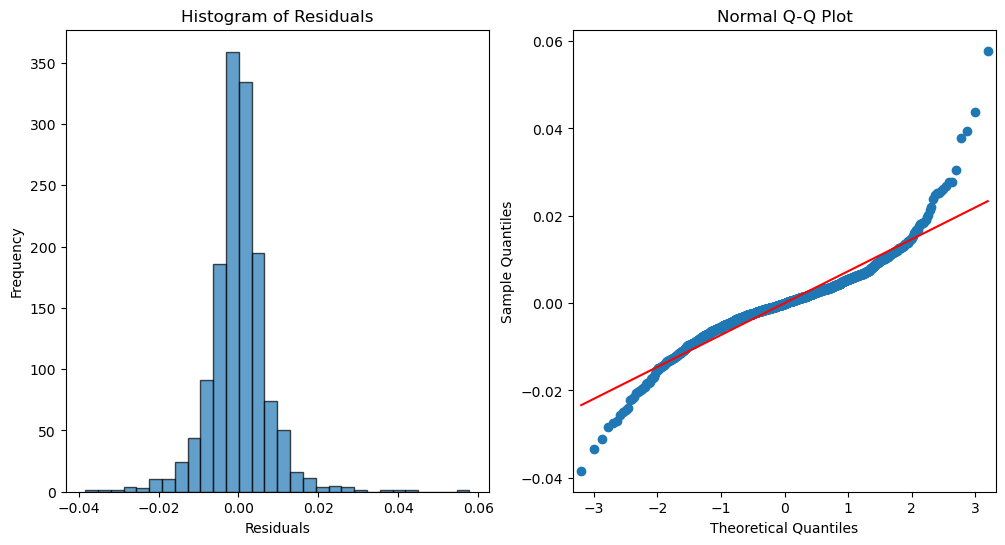

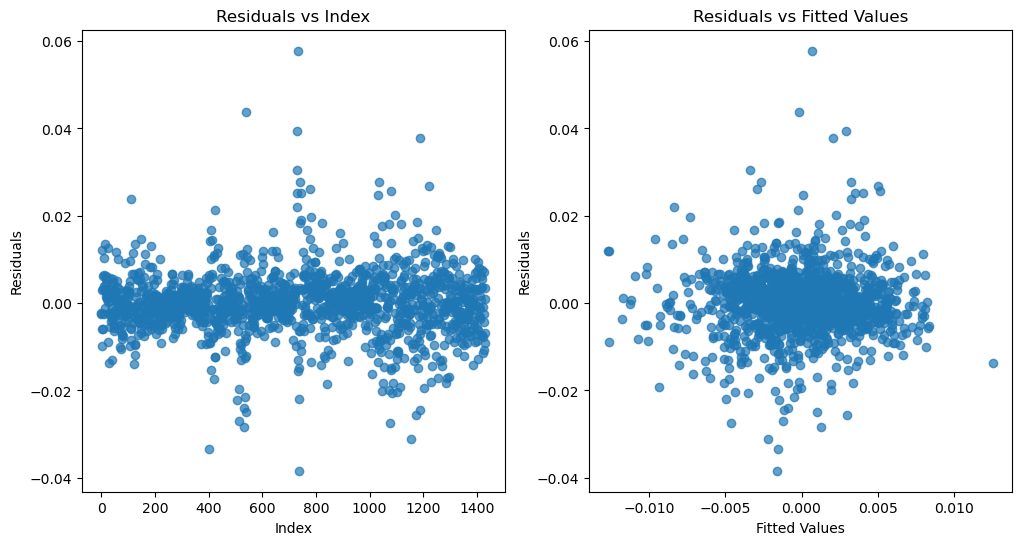

In [35]:
diagnosis_plot(model)

# Before daily trading

In [36]:
# Prepare the data for regression
X = sm.add_constant(beforeDailiy0dtePCTrading[["0dte_put_pct", "0dte_call_pct"]]) # independent variables
y = beforeDailiy0dtePCTrading['return']  # dependent variable

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     117.4
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           7.15e-47
Time:                        09:06:38   Log-Likelihood:                 3828.9
No. Observations:                1083   AIC:                            -7652.
Df Residuals:                    1080   BIC:                            -7637.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.000      2.751

# After daily trading

In [37]:
# Prepare the data for regression
X = sm.add_constant(afterDailiy0dtePCTrading[["0dte_put_pct", "0dte_call_pct"]]) # independent variables
y = afterDailiy0dtePCTrading['return']  # dependent variable

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     47.41
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           6.34e-19
Time:                        09:06:38   Log-Likelihood:                 1193.7
No. Observations:                 349   AIC:                            -2381.
Df Residuals:                     346   BIC:                            -2370.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.004      0.116

# Intraday 0DTE Impact

In [38]:
# Read CSV into a DataFrame
nDTEvolume = pd.read_csv("nDTEvolume.csv", dayfirst=True, index_col='index')
nDTEvolume['quote_minute'] = pd.to_datetime(nDTEvolume['quote_minute'])
zeroDTEvolume = nDTEvolume[nDTEvolume["ndte"]==0]

zeroDTEputvolume  = zeroDTEvolume[zeroDTEvolume["option_type"] == "P"]
zeroDTEcallvolume = zeroDTEvolume[zeroDTEvolume["option_type"] == "C"]

In [39]:
path = "C:\\Users\\bendi\\Desktop\\dataset\\spx.xlsx"
spx1minPrice = pd.read_excel(path, sheet_name="spx15august1min", parse_dates=['date'])
spx1minPrice['date'] = spx1minPrice['date'] - pd.Timedelta(hours=6)

In [40]:
# Merge dataframes on multiple columns
intradyData = pd.merge(zeroDTEputvolume, zeroDTEcallvolume, on='quote_minute', suffixes=('_put', '_call')).merge(spx1minPrice, left_on='quote_minute', right_on='date')
# Calculate put/call ratio
intradyData["put_call_ratio"] = intradyData["volume_put"] / intradyData["volume_call"]
# Drop redundant columns
intradyData = intradyData.drop(['date', 'option_type_put', 'option_type_call', 'ndte_call'], axis=1)
intradyData.rename(columns={'ndte_put': 'ndte'}, inplace=True)
intradyData

quote_minute  ndte  volume_put  volume_call  last_price  \
0   2023-08-15 09:30:00     0        5856         6409     4472.88   
1   2023-08-15 09:31:00     0        6728         9716     4471.11   
2   2023-08-15 09:32:00     0        4491         7712     4474.31   
3   2023-08-15 09:33:00     0        5309         4841     4472.59   
4   2023-08-15 09:34:00     0        3891         4024     4472.44   
..                  ...   ...         ...          ...         ...   
385 2023-08-15 15:55:00     0        3370         2975     4441.15   
386 2023-08-15 15:56:00     0        2960         2388     4440.22   
387 2023-08-15 15:57:00     0        1699         1355     4439.94   
388 2023-08-15 15:58:00     0        1877         1799     4441.45   
389 2023-08-15 15:59:00     0        2234         1500     4438.11   

     pct_change_next_1min  pct_change_current_1min  pct_change_prev_1min  \
0               -0.000396                      NaN                   NaN   
1                0.000715                 0.000396                   NaN   
2               -0.000385                -0.000716              0.000396   
3               -0.000034                 0.000384             -0.000716   
4               -0.000546                 0.000034              0.000384   
..                    ...                      ...                   ...   
385             -0.000209                -0.000735              0.000146   
386             -0.000063                 0.000209             -0.000735   
387              0.000340                 0.000063              0.000209   
388             -0.000753                -0.000340              0.000063   
389             -0.000072                 0.000752             -0.000340   

     pct_change_next_5min  put_call_ratio  
0                0.000644        0.913715  
1                0.000264        0.692466  
2                0.000961        0.582339  
3                0.000309        1.096674  
4               -0.000275        0.966948  
..                    ...             ...  
385              0.000757        1.132773  
386                   NaN        1.239531  
387                   NaN        1.253875  
388                   NaN        1.043357  
389                   NaN        1.489333  

[390 rows x 10 columns]

# 5 min intraday volatility and 0dte volume

In [41]:
# Calculate 5-minute volatility
intradyData['5min_volatility'] = intradyData['last_price'].rolling(window=5).std()
intradyData['0dte_volume'] = intradyData['volume_put'] + intradyData['volume_call']

# create a copy with the date as the index, and resample on 5 minute basis
copy = intradyData.copy()
copy.set_index('quote_minute', inplace=True)

resampled_df = copy.resample('5T').agg({
    'last_price': 'last',
    '5min_volatility': 'last',
    'volume_put': 'sum',
    'volume_call': 'sum',
    '0dte_volume': 'sum',
})
# Create the new column 'next_5min_volatility'
# resampled_df['next_5min_volatility'] = resampled_df['5min_volatility'].shift(-1)


# Prepare the data for regression
X = sm.add_constant(resampled_df[["0dte_volume"]]) # independent variables
y = resampled_df['5min_volatility']  # dependent variable

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())


print()
print("======================")
print("OLS Regression Results")
print("======================")
print("Data: periods of unbalanced 0dte put/call ratios")
print("Dep. Variable: 5min_volatility")
print("R-squared:  ",       "%.3f"  % model.rsquared)
print("p value:    ",       "%.3f" % model.pvalues["0dte_volume"])
print("coefficient:",       "%.7f" % model.params ["0dte_volume"])

                            OLS Regression Results                            
Dep. Variable:        5min_volatility   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     28.54
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           9.26e-07
Time:                        09:06:39   Log-Likelihood:                -53.003
No. Observations:                  78   AIC:                             110.0
Df Residuals:                      76   BIC:                             114.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4732      0.109      4.339      

In [42]:
# Scatter plot
scatter_trace = go.Scatter(x=resampled_df["0dte_volume"],
                          y=resampled_df["5min_volatility"],
                          mode='markers',
                          marker=dict(size=8),
                          name='Data')

# Regression line
regression_trace = go.Scatter(x=resampled_df["0dte_volume"],
                             y=model.predict(sm.add_constant(resampled_df[["0dte_volume"]])),
                             mode='lines',
                             line=dict(color='red', width=2),
                             name='Regression Line')

# Add text annotation
info_text = (
    f"R-squared: {model.rsquared:.3f}        <br>"
    f"P value:     {model.pvalues['0dte_volume']:.3f}        <br>"
    f"Coefficient: {model.params['0dte_volume']:.7f}"
)

annotation = dict(x=0.849,
                  y=0.877,
                  xref="paper",
                  yref="paper",
                  text=info_text,
                  showarrow=False,
                  font=dict(size=15),
                  bgcolor='lightgray',
                  bordercolor='black',
                  borderwidth=1,
                  borderpad=5,
                  xanchor='left',
                  yanchor='bottom')

# Create the figure
fig = go.Figure(data=[scatter_trace, regression_trace])

# Add annotation
fig.add_annotation(annotation)

# Set layout properties
fig.update_layout(title=f"Volatility and 0DTE volume " + resampled_df.index.min().strftime("%Y-%m-%d"),
                  xaxis_title="5 min 0DTE Volume",
                  yaxis_title="5 min Volatility",
                  xaxis=dict(range=[resampled_df["0dte_volume"].min()  *0.9, resampled_df["0dte_volume"].max()  *1.01]),
                  yaxis=dict(range=[resampled_df["5min_volatility"].min()*0.8, 2.7]))

# Show the plot
fig.show()
pyo.plot(fig, filename='regression3.html')

'regression3.html'

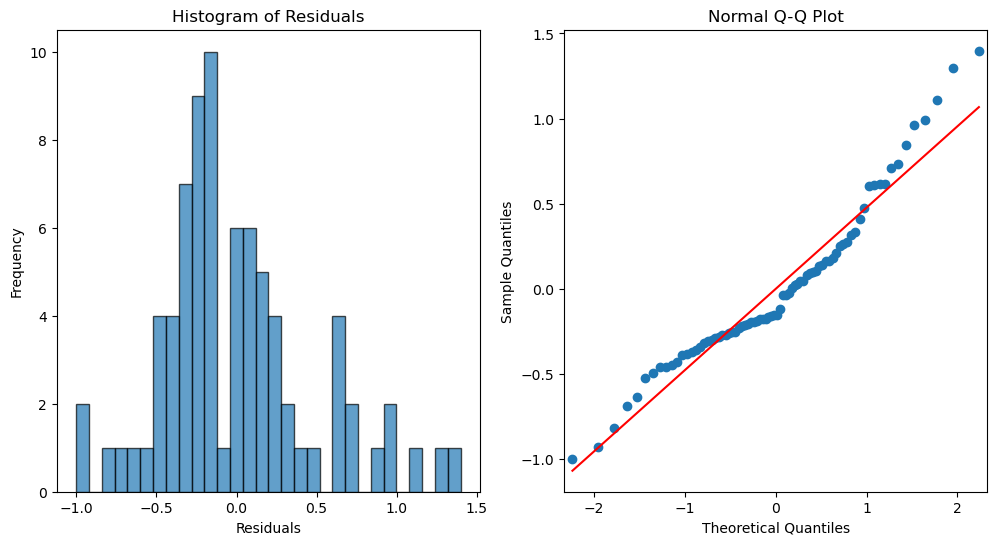

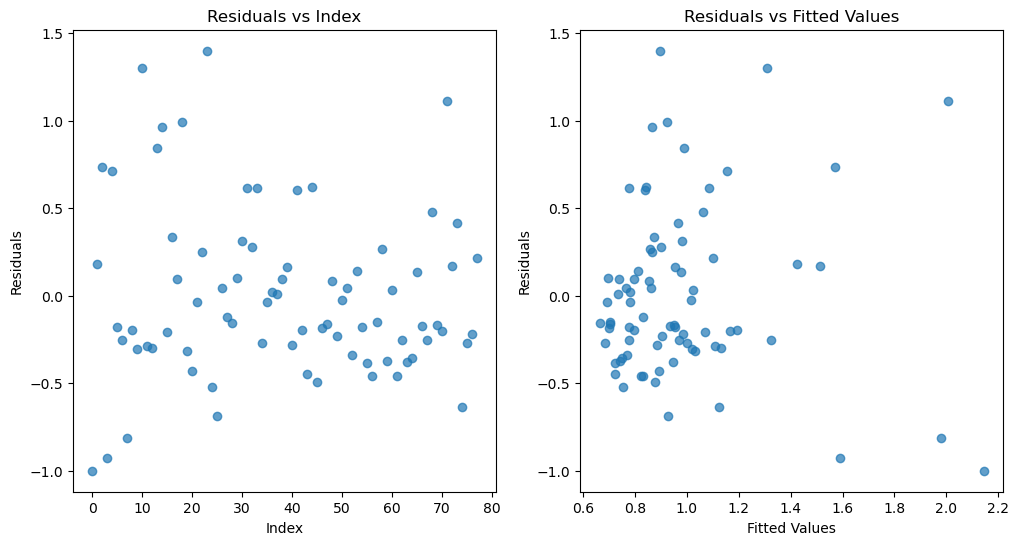

In [43]:
diagnosis_plot(model)

# Impact of imbalanced volumes
high p-value because of multicollinearity 

In [44]:
filtered = intradyData[(intradyData['put_call_ratio'] >= 55/45) | (intradyData['put_call_ratio'] <= 45/55)]

# Prepare the data for regression
X = sm.add_constant(filtered[["volume_put", "volume_call"]]) # independent variables
y = filtered['pct_change_next_1min']  # dependent variable

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())


print()
print("======================")
print("OLS Regression Results")
print("======================")
print("Data: periods of unbalanced 0dte put/call ratios")
print("Dep. Variable: pct_change_next_1min")
print("R-squared: ",           "%.3f"  % model.rsquared)
print("p value puts:  ",       "%.10f" % model.pvalues["volume_put"])
print("p value calls: ",       "%.10f" % model.pvalues["volume_call"])
print("coefficient puts: ",    "%.10f" % model.params ["volume_put"])
print("coefficient calls: ",   "%.10f" % model.params ["volume_call"])

                             OLS Regression Results                             
Dep. Variable:     pct_change_next_1min   R-squared:                       0.016
Model:                              OLS   Adj. R-squared:                  0.008
Method:                   Least Squares   F-statistic:                     1.905
Date:                  Tue, 07 Nov 2023   Prob (F-statistic):              0.151
Time:                          09:06:40   Log-Likelihood:                 1588.3
No. Observations:                   232   AIC:                            -3171.
Df Residuals:                       229   BIC:                            -3160.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.236e-05   2.99e

In [45]:
#for n in range(0,15000,500):    
print()
print()
#print(n, ratio, ratio2)
#filtered = intradyData[(intradyData['put_call_ratio'] >= ratio) | (intradyData['put_call_ratio'] <= ratio2)].dropna()
filtered = filtered[(filtered['volume_put'] >= n) | (filtered['volume_call'] >= n)].dropna()
#filtered = intradyData.dropna()
#if filtered.empty:
#    continue

# Prepare the data for regression
X = sm.add_constant(filtered[["volume_put", "volume_call"]]) # independent variables
y = filtered['pct_change_current_1min']  # dependent variable

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
#print(model.summary())


print()
print("======================")
print("OLS Regression Results")
print("======================")
print("Data: periods of unbalanced 0dte put/call ratios")
print("Dep. Variable: ")
print("R-squared: ",           "%.3f"  % model.rsquared)
print("p value puts:  ",       "%.10f" % model.pvalues["volume_put"])
print("p value calls: ",       "%.10f" % model.pvalues["volume_call"])
print("coefficient puts: ",    "%.10f" % model.params ["volume_put"])
print("coefficient calls: ",   "%.10f" % model.params ["volume_call"])




OLS Regression Results
Data: periods of unbalanced 0dte put/call ratios
Dep. Variable: 
R-squared:  0.236
p value puts:   0.0000000000
p value calls:  0.0480996959
coefficient puts:  0.0000000871
coefficient calls:  -0.0000000394


In [46]:
filtered.shape

(227, 12)

In [47]:
print("===========================================================")
print("One-Minute S&P 500 Price Variations on 8/15/2023 (% change)")
print("===========================================================")
print("Largest rally:       ", "%.5f" % intradyData["pct_change_prev_1min"].max())
print("Largest decline:    ",  "%.5f" % intradyData["pct_change_prev_1min"].min())
print("Mean of abs values:  ", "%.5f" % abs(intradyData["pct_change_prev_1min"]).mean())
print("Median of abs values:", "%.5f" % abs(intradyData["pct_change_prev_1min"]).median())

One-Minute S&P 500 Price Variations on 8/15/2023 (% change)
Largest rally:        0.00117
Largest decline:     -0.00082
Mean of abs values:   0.00019
Median of abs values: 0.00015


In [48]:
filtered["volume_put"].std()

1799.345364500892

In [49]:
a = 2410*0.0000000240
f"%.10f" % a

'0.0000578400'

In [50]:
filtered["volume_put"].mean()

1871.9162995594713

In [51]:
filtered["volume_call"].mean()

1769.8149779735684

In [52]:
a = 4112*0.0000000240
f"%.10f" % a

'0.0000986880'

# Intraday impact of large 0dte volumes

In [53]:
filtered = intradyData[(intradyData['volume_put'] >= 3000) | (intradyData['volume_call'] >= 3000)]

# Prepare the data for regression
X = sm.add_constant(filtered[["volume_put", "volume_call"]]) # independent variables
y = filtered['pct_change_next_1min']  # dependent variable

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

print()
print("======================")
print("OLS Regression Results")
print("======================")
print("Data: periods of large 0dte put or call volumes")
print("Dep. Variable: pct_change_next_1min")
print("R-squared: ",           "%.3f"  % model.rsquared)
print("p value puts:  ",       "%.10f" % model.pvalues["volume_put"])
print("p value calls: ",       "%.10f" % model.pvalues["volume_call"])
print("coefficient puts: ",    "%.10f" % model.params ["volume_put"])
print("coefficient calls: ",   "%.10f" % model.params ["volume_call"])

                             OLS Regression Results                             
Dep. Variable:     pct_change_next_1min   R-squared:                       0.063
Model:                              OLS   Adj. R-squared:                  0.032
Method:                   Least Squares   F-statistic:                     2.068
Date:                  Tue, 07 Nov 2023   Prob (F-statistic):              0.135
Time:                          09:06:40   Log-Likelihood:                 436.64
No. Observations:                    65   AIC:                            -867.3
Df Residuals:                        62   BIC:                            -860.8
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0001      0.

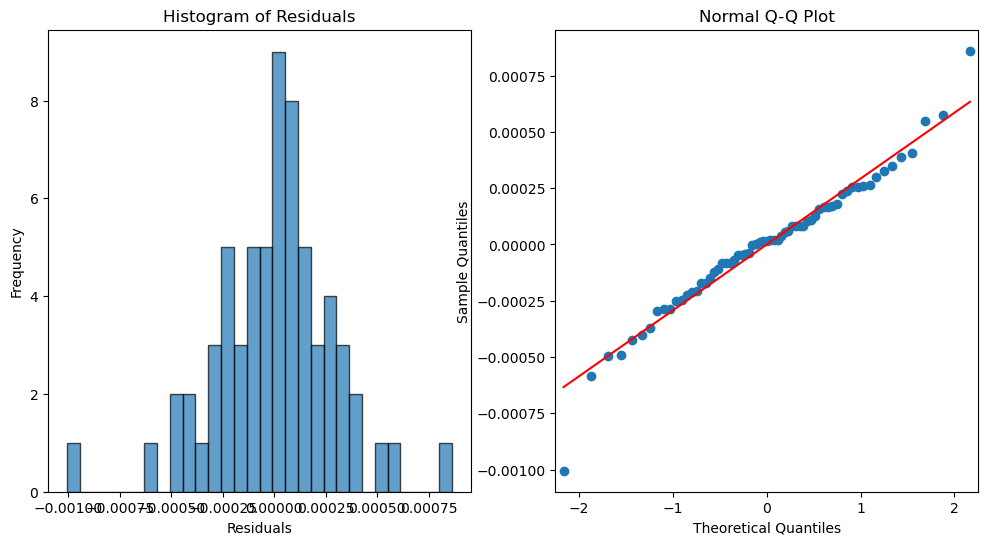

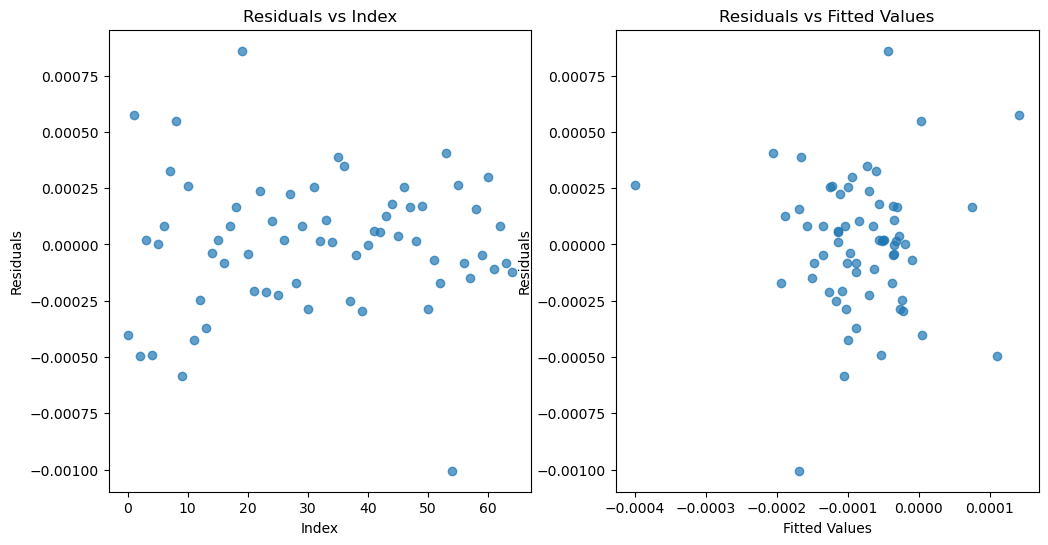

In [54]:
diagnosis_plot(model)

# Plots

In [55]:
zeroDTEputvolume

quote_minute  ndte option_type  volume
index                                              
10    2023-08-15 09:30:00     0           P    5856
58    2023-08-15 09:31:00     0           P    6728
110   2023-08-15 09:32:00     0           P    4491
151   2023-08-15 09:33:00     0           P    5309
197   2023-08-15 09:34:00     0           P    3891
...                   ...   ...         ...     ...
14746 2023-08-15 15:55:00     0           P    3370
14795 2023-08-15 15:56:00     0           P    2960
14843 2023-08-15 15:57:00     0           P    1699
14891 2023-08-15 15:58:00     0           P    1877
14941 2023-08-15 15:59:00     0           P    2234

[390 rows x 4 columns]

In [56]:
zeroDTEputvolume["rolling_average_volume"]  = zeroDTEputvolume["volume"] .rolling(window=10, center=True).mean()
zeroDTEcallvolume["rolling_average_volume"] = zeroDTEcallvolume["volume"].rolling(window=10, center=True).mean()

Put_trace = go.Bar(
    x=zeroDTEputvolume["quote_minute"], 
    y=zeroDTEputvolume["volume"],
    name='0DTE Puts',
    marker=dict(color='rgba(255,165,0,0.5)'))

Call_trace = go.Bar(
    x=zeroDTEcallvolume["quote_minute"], 
    y=zeroDTEcallvolume["volume"],
    name='0DTE Calls',
    marker=dict(color='rgba(255,255,0,0.5)'))

Put_Smoothed_trace = go.Scatter(
    x=zeroDTEputvolume["quote_minute"], 
    y=zeroDTEputvolume["rolling_average_volume"], 
    mode='lines', 
    name='Smoothed 0DTE Put Volume', 
    line=dict(color='orange'), opacity=1)

Call_Smoothed_trace = go.Scatter(
    x=zeroDTEcallvolume["quote_minute"], 
    y=zeroDTEcallvolume["rolling_average_volume"], 
    mode='lines', 
    name='Smoothed 0DTE Call Volume', 
    line=dict(color='yellow'), opacity=1)

Price_trace = go.Scatter(
    x=spx1minPrice["date"], 
    y=spx1minPrice["last_price"], 
    yaxis='y2', 
    mode='lines', 
    name='S&P 500', 
    line=dict(color='blue'))


# Create layout
layout = go.Layout(
    title=f'0DTE Options volume aggregate per minute and the S&P 500 index',
    
    yaxis=dict(title='Options Volume', side='right', showgrid=False),
    yaxis2=dict(title='S&P 500 Price', side='left', overlaying='y'),
    
    barmode='group'
)


# Create figure and add traces
fig = go.Figure(data=[Price_trace, Put_trace, Call_trace, Call_Smoothed_trace, Put_Smoothed_trace], layout=layout)

fig.update_layout(
    yaxis =dict(range=[0, 18000])
)

# Display the plot
fig.show()
pyo.plot(fig, filename='intradayOverview.html')

C:\Users\bendi\AppData\Local\Temp\ipykernel_16636\957086917.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bendi\AppData\Local\Temp\ipykernel_16636\957086917.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bendi\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavi

'intradayOverview.html'

In [57]:
Put_trace = go.Bar(
    x=zeroDTEputvolume["quote_minute"], 
    y=zeroDTEputvolume["volume"],
    name='0DTE Puts',
    marker=dict(color='orange'))
    #marker=dict(color=['darkorange' if t>5000 else 'rgba(255,165,0,0.4)' for t in zeroDTEputvolume["volume"]]))

Call_trace = go.Bar(
    x=zeroDTEcallvolume["quote_minute"], 
    y=zeroDTEcallvolume["volume"],
    name='0DTE Calls',
    marker=dict(color='yellow'))
    #marker=dict(color='rgba(255,255,0,0.4)'))

fall_data = spx1minPrice[(spx1minPrice["date"]>=datetime(2023,8,15,15,22)) & (spx1minPrice["date"]<=datetime(2023,8,15,15,32))]

SharpFall_trace = go.Scatter(
    x=fall_data["date"], 
    y=fall_data["last_price"], 
    yaxis='y2', 
    mode='lines', 
    showlegend=False,
    line=dict(color='blue', width=5))
Price_trace = go.Scatter(
    x=spx1minPrice["date"], 
    y=spx1minPrice["last_price"], 
    yaxis='y2', 
    mode='lines', 
    name='S&P 500', 
    line=dict(color='blue', width=1))

fig = go.Figure(data=[Price_trace, Put_trace, Call_trace, SharpFall_trace], layout=layout)

fig.update_layout(
    yaxis =dict(range=[0, 18000]),
    yaxis2=dict(range=[4432, 4452.5]),
    xaxis =dict(range=[datetime(2023,8,15,15), datetime(2023,8,15,16)]),
)
fig.show()
pyo.plot(fig, filename='intradayZoom.html')

'intradayZoom.html'

In [58]:
PC_ratio = go.Scatter(
    x=intradyData["quote_minute"], 
    y=intradyData["put_call_ratio"], 
    mode='lines', 
    name='Put/Call ratio', 
    line=dict(color='black'), opacity=0.5)

Price_trace = go.Scatter(
    x=intradyData["quote_minute"], 
    y=intradyData["last_price"], 
    yaxis='y2', 
    mode='lines', 
    name='S&P 500', 
    line=dict(color='blue'))


# Create layout
layout = go.Layout(
    title=f'The S&P 500 index and 0DTE Putt/Call Ratio',
    
    yaxis=dict(title='Put/Call ratio', side='right', showgrid=False),
    yaxis2=dict(title='S&P 500 Price', side='left', overlaying='y'),
)


# Create figure and add traces
fig = go.Figure(data=[Price_trace, PC_ratio], layout=layout)

# Display the plot
fig.show()
pyo.plot(fig, filename='putCallRatio.html')

'putCallRatio.html'

# Delta

In [59]:
# Read CSV into a DataFrame
option_delta = pd.read_csv("option_delta.csv", dayfirst=True)
option_delta['date'] = pd.to_datetime(option_delta['date'])
option_delta = option_delta.dropna()

In [60]:
ndte = 0
strike_index_ratio = 0.1

option_delta_filtered = option_delta[(option_delta['ndte'] == ndte) & (option_delta['strike_index_ratio'] == strike_index_ratio) & (option_delta['mean_delta'] < 1)]

smooth = option_delta_filtered.groupby(option_delta_filtered['date'].dt.to_period("M"))['mean_delta'].mean().rolling(window=5, center=True).mean()
smooth = pd.DataFrame({'month': smooth.index, 'smooth': smooth.values})

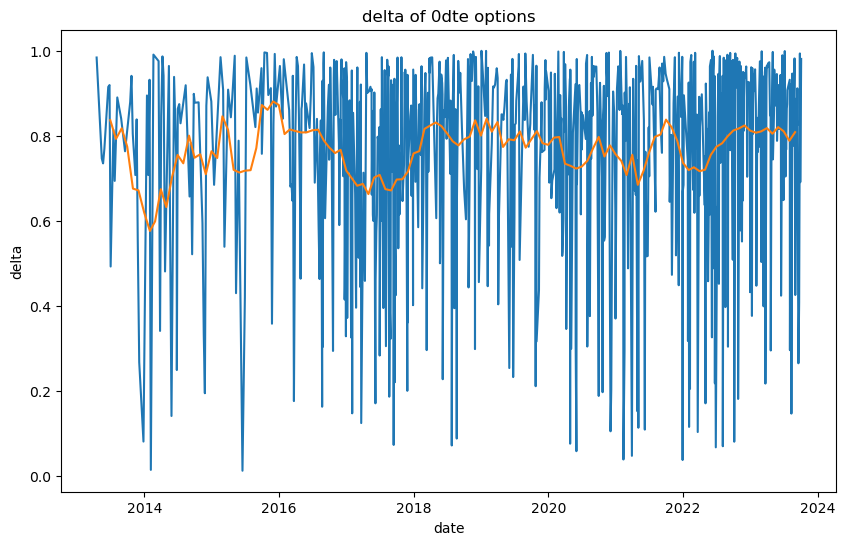

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(option_delta_filtered["date"], option_delta_filtered["mean_delta"])
plt.plot(smooth["month"], smooth["smooth"])
plt.xlabel("date")
plt.ylabel("delta")
plt.title(f"delta of {ndte}dte options")
plt.show()